
# Demo: training an image classifier


(Adapted from official PyTorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Initial settings

Enable plotting and import `PyTorch, Matplotlib` and `Numpy`

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## CIFAR-10 dataset

https://www.cs.toronto.edu/~kriz/cifar.html

One of the most widely used dataset for benchmarking machine learning and computer vision models.

It consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Download CIFAR-10 from `torchvision`.

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/Colab Notebooks/ANN/Classification_demo/dataTrain', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='/content/gdrive/MyDrive/Colab Notebooks/ANN/Classification_demo/dataTest', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 77259885.08it/s]


Extracting /content/gdrive/MyDrive/Colab Notebooks/ANN/Classification_demo/dataTrain/cifar-10-python.tar.gz to /content/gdrive/MyDrive/Colab Notebooks/ANN/Classification_demo/dataTrain


100%|██████████| 170498071/170498071 [00:02<00:00, 80563114.45it/s]


Extracting /content/gdrive/MyDrive/Colab Notebooks/ANN/Classification_demo/dataTest/cifar-10-python.tar.gz to /content/gdrive/MyDrive/Colab Notebooks/ANN/Classification_demo/dataTest


Have a look at few of the images



In [7]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# get some random training images
dataiter = iter(trainloader)
for images, labels in dataiter:
    imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Output hidden; open in https://colab.research.google.com to view.

Explore data to understand structure and content


In [9]:
print(f"Shape of image data: {images.shape}; shape of labels: {labels.shape}")

Shape of image data: torch.Size([4, 3, 32, 32]); shape of labels: torch.Size([4])


What do the numbers mean?

PyTorch uses the **N**umber, **C**hannel, **H**eight, **W**idth (NCHW) convention for image RGB data.

An RGB image is a 3D tensor (3d matrix):

<center>
<img src="rgb.png" alt="rgb" width="500" align="center"/>
</center>

Explore a bit more

In [10]:
print(f"Each image is: {images[0].shape}")
print(f"Example values: {images[0, 0, :5, :5]}")
print(f"Minimum and maximum vallue: ({images.min()}, {images.max()})")
print(f"Number of unique values: {torch.numel(images.unique())}")

Each image is: torch.Size([3, 32, 32])
Example values: tensor([[0.7686, 0.7843, 0.6824, 0.5412, 0.5451],
        [0.5176, 0.6824, 0.6275, 0.4745, 0.4471],
        [0.2039, 0.5647, 0.5373, 0.3608, 0.2902],
        [0.2431, 0.4510, 0.5098, 0.3608, 0.2431],
        [0.5176, 0.5490, 0.5333, 0.3725, 0.2824]])
Minimum and maximum vallue: (0.003921568859368563, 1.0)
Number of unique values: 255


How many unique values would you expect?

Let's look at the labels

In [12]:
print(f"Labels: {labels}")

Labels: tensor([8, 9, 7, 3])


What are these numbers?

# Classification problem

Write programm which takes as input an RGB image and outputs what is in it (class).

How would you go around it?

**Machine learning:** choose a model - hypothesis class

**Deep learning:** choose a deep learning model (here Convolutional Neural Network - CNN)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Instantiate the CNN model

In [14]:
image_net = CNN()
print(image_net)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Test the CNN model on unseen (test) data

In [24]:
def test_model(model, dataiter):
    images, labels = next(dataiter)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

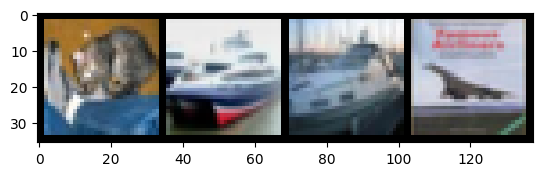

GroundTruth:    cat  ship  ship plane
Predicted:    dog   car  ship  ship


In [25]:
testiter = iter(testloader)
test_model(image_net, testiter)

Do the predictions match the ground truth?

Let's check overall performance

In [17]:
def model_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}")

In [18]:
model_accuracy(image_net, testloader)

Accuracy of the network on the 10000 test images: 10.01


Why is the accuracy around 10%?



Let's check performance for individual classes

In [19]:
def class_accuracy(model, data_loader):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in data_loader:
            images, labels = data    
            outputs = model(images)    
            _, predictions = torch.max(outputs, 1)
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f"Accuracy for class {classname} is: {accuracy}")

In [20]:
class_accuracy(image_net, testloader)

Accuracy for class plane is: 0.0
Accuracy for class car is: 0.0
Accuracy for class bird is: 99.5
Accuracy for class cat is: 0.0
Accuracy for class deer is: 0.0
Accuracy for class dog is: 0.0
Accuracy for class frog is: 0.0
Accuracy for class horse is: 0.0
Accuracy for class ship is: 0.6
Accuracy for class truck is: 0.0


# What's missing?

Define the **loss** function and **optimizer**

In [21]:
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(image_net.parameters(), lr=0.001, momentum=0.9)

Finally, **train the model** (optimize the parameters of the CNN).

In [22]:
def train_model(model, data_loader, epochs):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossfunc(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f"[{epoch+1}, {i+1}] loss: {running_loss / 2000}")
                running_loss = 0.0
    print('Finished Training')

In [23]:
train_model(image_net, trainloader, 5)

[1, 2000] loss: 2.3007085295915606
[1, 4000] loss: 2.175696873307228
[1, 6000] loss: 1.955921495437622
[1, 8000] loss: 1.7792865235209465
[1, 10000] loss: 1.684876062825322
[1, 12000] loss: 1.6217860806584359
[2, 2000] loss: 1.5318386440575122
[2, 4000] loss: 1.5195698503255843
[2, 6000] loss: 1.5027499974519014
[2, 8000] loss: 1.494443812303245
[2, 10000] loss: 1.4393808151334524
[2, 12000] loss: 1.4463251423388719
[3, 2000] loss: 1.3755934266224503
[3, 4000] loss: 1.3513374518938364
[3, 6000] loss: 1.3569559075236322
[3, 8000] loss: 1.3412553875669837
[3, 10000] loss: 1.3261289787068964
[3, 12000] loss: 1.3301989313066005
[4, 2000] loss: 1.2777455525621773
[4, 4000] loss: 1.2606798020265997
[4, 6000] loss: 1.282509340494871
[4, 8000] loss: 1.2420357213057578
[4, 10000] loss: 1.2438558483235538
[4, 12000] loss: 1.2413304899185895
[5, 2000] loss: 1.1804099657610059
[5, 4000] loss: 1.1713716250322759
[5, 6000] loss: 1.1756017713621258
[5, 8000] loss: 1.192916478603147
[5, 10000] loss: 1

Test the model again on unseen classes

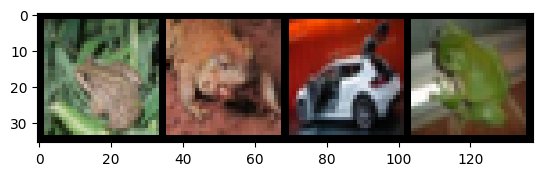

GroundTruth:   frog  frog   car  frog
Predicted:   deer  deer   car  frog


In [26]:
test_model(image_net, testiter)

Let's check overall performance again

In [27]:
model_accuracy(image_net, testloader)

Accuracy of the network on the 10000 test images: 57.28


This seems a lot better!

Let's check performance for individual classes

In [28]:
class_accuracy(image_net, testloader)

Accuracy for class plane is: 57.3
Accuracy for class car is: 75.0
Accuracy for class bird is: 42.6
Accuracy for class cat is: 27.6
Accuracy for class deer is: 65.1
Accuracy for class dog is: 44.4
Accuracy for class frog is: 54.8
Accuracy for class horse is: 71.2
Accuracy for class ship is: 72.1
Accuracy for class truck is: 62.7
